In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install astroNN

     |████████████████████████████████| 9.3 MB 18.6 MB/s 
     |████████████████████████████████| 4.5 MB 47.4 MB/s 
     |████████████████████████████████| 832 kB 81.7 MB/s 
     |████████████████████████████████| 48 kB 6.6 MB/s 
     |████████████████████████████████| 4.0 MB 56.4 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284595 sha256=4e72c29cd5dd7347cc08555d11feb190b0ae5e2f592f1bb293b98fe382c4f56e
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astroNN


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random
random.seed(42)
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Resizing
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping

import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

#loading the file instead of from the model (which is crashing my computer)
import astroNN
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

In [4]:
# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
from astroNN.datasets import load_galaxy10 

images, labels = load_galaxy10()   #this has the same amount of classified image data just like galaxy10.load_data()!!

labels

#BEFORE CONVERTING THEM.. THE ORIGINAL DATASET IS IN UINT8 TYPE!!!!
# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

Galaxy10.h5: 100%|█████████▉| 210M/210M [00:20<00:00, 14.0MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:21, 9.82MB/s]                           


In [5]:
# To convert to desirable type
labels_conv = labels.astype(np.float32)
images_conv = images.astype(np.float32)
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
                                                #scale the input data (the pixels between 0s and 1s!!)
train_images, train_labels, test_images, test_labels = images_conv[train_idx]/255, labels_conv[train_idx], images_conv[test_idx]/255, labels_conv[test_idx]

In [6]:
# ds = tf.data.Dataset.from_tensor_slices(train_images).\
#     map(lambda x: tf.image.resize(x, (224, 224)))

# print(next(iter(ds)))

In [7]:
#for inceptionv3 input size needs to be greater then 75
size = (76, 76)

train_images_resized = tf.image.resize(train_images, size)


In [8]:
test_images_resized = tf.image.resize(test_images, size)

In [9]:
train_images_resized.shape

TensorShape([19606, 76, 76, 3])

In [10]:
#train_images_resized[0][np.newaxis, ...]

In [11]:
# m = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_050_160/classification/5", )
# ])

In [12]:
# result = m.predict(train_images_resized[0][np.newaxis, ...])

In [13]:
# np.argmax(result, axis = 1)

In [14]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
# image_labels = []
# with open("ImageNetLabels.txt", "r") as f:
#     image_labels = f.read().splitlines()

In [15]:
# IMG_SIZE = 224

# resize_and_rescale = tf.keras.Sequential([
#   Resizing(IMG_SIZE, IMG_SIZE),
#   #layers.Rescaling(1./255) #dont need to rescale.. did it above
# ])

In [16]:
# feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# pretrained_model_without_top_layer = hub.KerasLayer(
#     feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [17]:
# model = tf.keras.Sequential([
#   resize_and_rescale,
#   pretrained_model_without_top_layer,
#   tf.keras.layers.Dense(10, activation='softmax')
# ])

# model.build(train_images[0].shape)

# model.summary()

In [18]:
len(test_images_resized) // 32

68

In [19]:
# x = 5 #this is in memory

# x = pd.load_csv()  ## this is from cold storage now in memory!


#datagenerator does a load on  .. i only want load these indexes.. asigns these indexes into a batch.. only loads one batch at a time
#say you have a huge dataset.. you cant put it all onto your ram or it will crash.. it does it in batches i.e loads it in small amounts at a time
# then removes it then does the next batch 

In [27]:
def plot_hist(hist, metric = "loss"):
    """ plot the results from neural net training 
    
    Args:
        hist (TF history object): The history of the training
        metric (string): The name of the metric to plot (name should be the same as key in hist.history)
    
    Returns: 
        None
    """
    
    plt.figure(figsize=(12, 8))

    plt.plot(hist.history[metric], label=f'Train {metric.capitalize()}')
    plt.plot(hist.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

    plt.title(f'Training & Testing {metric.capitalize()} by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel(metric.capitalize(), fontsize=18)

    plt.legend(fontsize=18);

In [21]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
# model.fit_generator(train_images_resized, train_labels,
#                     validation_data= (test_images_resized, test_labels),
#                     steps_per_epoch = 68,
#                     epochs = 10) 
model.fit(train_images_resized, train_labels, batch_size= 32, epochs = 10)
#load in the data and pass it through fit like normal

#
#


87924736/87910968 [==============================] - 3s 0us/step
Epoch 1/10
613/613 [==============================] - 25s 19ms/step - loss: 1.1337
Epoch 2/10
613/613 [==============================] - 11s 17ms/step - loss: 0.9235
Epoch 3/10
613/613 [==============================] - 11s 18ms/step - loss: 0.8565
Epoch 4/10
613/613 [==============================] - 12s 19ms/step - loss: 0.7988
Epoch 5/10
613/613 [==============================] - 12s 19ms/step - loss: 0.7467
Epoch 6/10
613/613 [==============================] - 11s 18ms/step - loss: 0.6927
Epoch 7/10
613/613 [==============================] - 11s 18ms/step - loss: 0.6423
Epoch 8/10
613/613 [==============================] - 11s 18ms/step - loss: 0.5876
Epoch 9/10
613/613 [==============================] - 11s 18ms/step - loss: 0.5402
Epoch 10/10
613/613 [==============================] - 11s 18ms/step - loss: 0.4988


In [22]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)



0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [24]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from keras.optimizers import SGD
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
tl_model = model.fit(train_images_resized, train_labels,
          batch_size = 256, epochs = 100,
          validation_data=(test_images_resized, test_labels),
          callbacks = EarlyStopping(patience=30))

Epoch 1/100
77/77 [==============================] - 14s 113ms/step - loss: 4.3217 - accuracy: 0.4890 - val_loss: 26.7819 - val_accuracy: 0.3419
Epoch 2/100
77/77 [==============================] - 6s 78ms/step - loss: 1.4760 - accuracy: 0.6144 - val_loss: 18.9124 - val_accuracy: 0.5691
Epoch 3/100
77/77 [==============================] - 6s 78ms/step - loss: 1.1735 - accuracy: 0.6831 - val_loss: 1.9298 - val_accuracy: 0.6140
Epoch 4/100
77/77 [==============================] - 6s 78ms/step - loss: 1.3653 - accuracy: 0.6995 - val_loss: 1.3615 - val_accuracy: 0.6714
Epoch 5/100
77/77 [==============================] - 6s 78ms/step - loss: 1.6734 - accuracy: 0.7041 - val_loss: 131.0832 - val_accuracy: 0.2795
Epoch 6/100
77/77 [==============================] - 6s 78ms/step - loss: 1.2646 - accuracy: 0.6903 - val_loss: 34.7426 - val_accuracy: 0.6145
Epoch 7/100
77/77 [==============================] - 6s 78ms/step - loss: 0.9835 - accuracy: 0.7295 - val_loss: 12.1039 - val_accuracy: 0.606

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

In [ ]:

# #compile the model
# cnn_model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

# #FIT ON TRAINING DATA
# cnn_hist = cnn_model.fit(train_images_v2, train_labels_v2_encoded,
#                          batch_size=256, epochs = 100,
#                          validation_data=(test_images, test_labels),
#                          callbacks=EarlyStopping(patience=10))

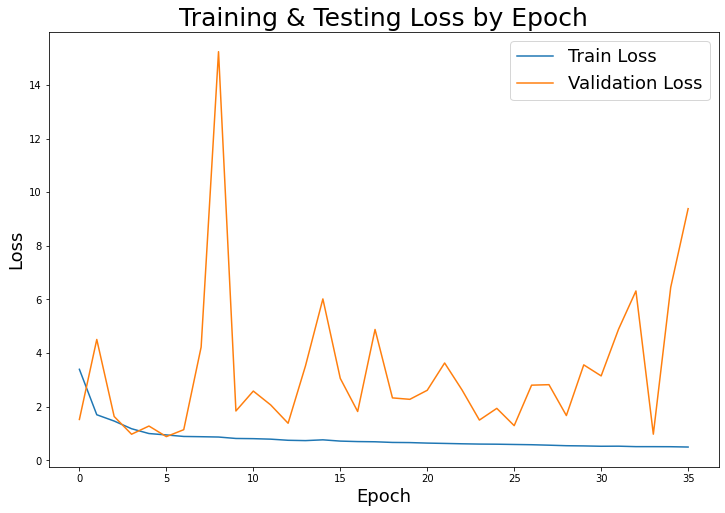

In [ ]:
plot_hist(tl_model, 'loss')

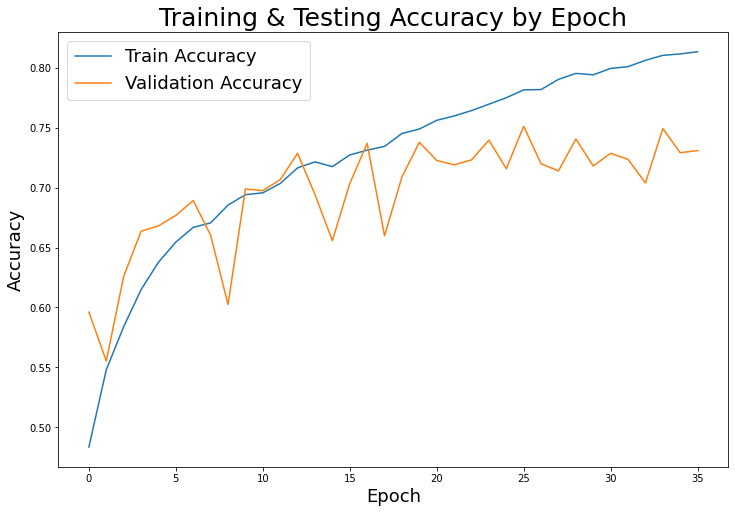

In [ ]:
plot_hist(tl_model, 'accuracy')

In [ ]:

# classifier = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=train_images[0].shape)
# ])

In [ ]:
tl_model.model.history.history['val_loss'][-1]

9.385538101196289

In [ ]:
test_pred = tl_model.model.predict(test_images_resized)
test_pred

array([[2.6123650e-02, 9.5570970e-01, 1.7973624e-02, ..., 1.9288014e-04,
        8.3607546e-08, 7.4169046e-11],
       [3.8985774e-02, 8.3522335e-02, 8.7735951e-01, ..., 1.2280377e-04,
        4.1946322e-07, 9.2621008e-08],
       [1.7504833e-03, 7.2222006e-01, 2.7602941e-01, ..., 2.8931144e-10,
        7.4911614e-23, 6.7331583e-26],
       ...,
       [2.0573473e-02, 9.7882503e-01, 6.0148031e-04, ..., 9.3218863e-18,
        0.0000000e+00, 0.0000000e+00],
       [6.3073542e-03, 1.4293943e-01, 8.5075140e-01, ..., 1.7767148e-06,
        1.2705060e-15, 3.4216309e-18],
       [1.3568237e-01, 8.1471866e-01, 4.9598537e-02, ..., 3.3682190e-07,
        9.4547708e-14, 2.7988118e-16]], dtype=float32)

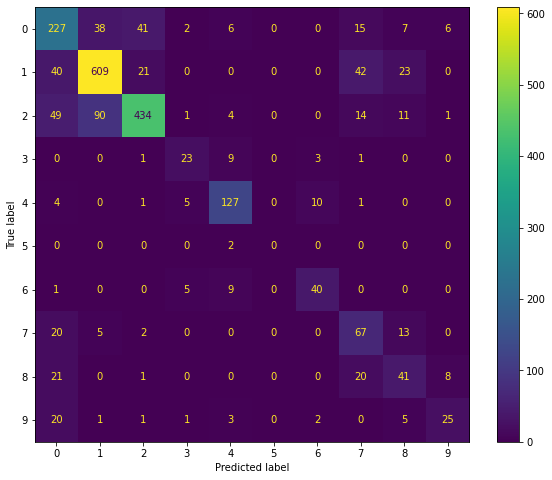

In [ ]:
# Display results in a confusion matrix (older method for sklearn < 1.0) - multiclass classification - 0 to 9 classes
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), test_pred.argmax(axis=1), ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))

Accuracy Score : 0.7310692978430473


In [ ]:
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights:

F1 score of each class:  [0.62707182 0.8240866  0.78481013 0.62162162 0.82467532 0.
 0.72727273 0.50187266 0.42931937 0.51020408]
F1_score (micro):  0.7310692978430474
F1_score (macro):  0.5850934339411072
F1_score (weighted):  0.735015950308966


In [ ]:
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights:

In [23]:
#====================== BALANCED DATASET=====================================================================
#load in the balanced dataset :
#: ***************************#unshuffled
train_images_v3 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/BalancedTrainImages_and_augImages.npy', allow_pickle=True)
#resize bec inputs this transfer learning has a minimum input size
train_images_v3 = tf.image.resize(train_images_v3, size)


train_labels_v3 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/LABELS_BalanceTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v3_encoded = utils.to_categorical(train_labels_v3, 10)
train_labels_v3_encoded[-1], train_labels_v3.shape, train_images_v3.shape

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 (40000,),
 (40000, 69, 69, 3))

In [27]:
# #train test split the data and combine it after   -- shuffling method also
# X_train, X_test, y_train, y_test = train_test_split(train_images_v3, train_labels_v3_encoded, stratify= train_labels_v3_encoded, random_state=42 )
# X_trainv2 = np.concatenate((X_train, X_test))
# y_trainv2 = np.concatenate((y_train, y_test))
# X_trainv2.shape, y_trainv2.shape


((40000, 69, 69, 3), (40000, 10))

In [23]:
# #then save it#===================================================================================================================================================================
# np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrainImages_and_augImages.npy', X_trainv2, allow_pickle=True)
# np.save('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrain_Labels.npy', y_trainv2, allow_pickle=True)

# #load it so we dont have re run alot of the code again: ++++++++++++++++++++++++++++++++++++++++++++====================================
train_images_v3_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrainImages_and_augImages.npy', allow_pickle=True)

#resize---------
train_images_v3_shuffled = tf.image.resize(train_images_v3_shuffled, size)


train_labels_v3_encoded_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledBalancedTrain_Labels.npy', allow_pickle=True)

train_images_v3_shuffled.shape, train_labels_v3_encoded_shuffled.shape

((40000, 69, 69, 3), (40000, 10))

TensorShape([40000, 76, 76, 3])

TensorShape([40000, 76, 76, 3])

In [ ]:
#====================== BALANCED DATASET=====================================================================

In [26]:
#-------------------------------------SHUFFLED----------------------------------------------
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from keras.optimizers import SGD
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
tl_model = model.fit(train_images_v3_shuffled, train_labels_v3_encoded_shuffled,
          batch_size = 256, epochs = 100,
          validation_data=(test_images_resized, test_labels),
          callbacks = EarlyStopping(patience=30))

Epoch 1/100
157/157 [==============================] - 20s 90ms/step - loss: 3.9950 - accuracy: 0.3558 - val_loss: 1.8264 - val_accuracy: 0.3414
Epoch 2/100
157/157 [==============================] - 12s 77ms/step - loss: 1.2954 - accuracy: 0.5116 - val_loss: 1.0069 - val_accuracy: 0.6186
Epoch 3/100
157/157 [==============================] - 12s 77ms/step - loss: 1.0610 - accuracy: 0.6144 - val_loss: 0.7540 - val_accuracy: 0.7077
Epoch 4/100
157/157 [==============================] - 12s 76ms/step - loss: 0.9882 - accuracy: 0.6525 - val_loss: 0.7477 - val_accuracy: 0.7178
Epoch 5/100
157/157 [==============================] - 12s 76ms/step - loss: 1.0252 - accuracy: 0.6781 - val_loss: 0.6874 - val_accuracy: 0.7366
Epoch 6/100
157/157 [==============================] - 12s 76ms/step - loss: 1.0423 - accuracy: 0.6910 - val_loss: 0.8973 - val_accuracy: 0.6434
Epoch 7/100
157/157 [==============================] - 12s 75ms/step - loss: 0.9415 - accuracy: 0.7089 - val_loss: 0.6546 - val_ac

In [ ]:
#-------------------------------------UNSHUFFLED----------------------------------------------
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from keras.optimizers import SGD
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
tl_model = model.fit(train_images_v3, train_labels_v3,
          batch_size = 256, epochs = 100,
          validation_data=(test_images_resized, test_labels),
          callbacks = EarlyStopping(patience=30))

In [ ]:
#============================= UNBALANCED DATASET====================================================

In [24]:
#SHUFFLED ++++++++++++++++++++++++++++++++++++++++++++====================================

train_images_v2_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledOriginalTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v2_encoded_shuffled = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/ShuffledOriginalTrain_Labels.npy', allow_pickle=True)


#resize image set to preprocess for transfer learning
train_images_v2_shuffled = tf.image.resize(train_images_v2_shuffled, size)



train_images_v2_shuffled.shape, train_labels_v2_encoded_shuffled.shape

(TensorShape([43960, 76, 76, 3]), (43960, 10))

In [ ]:
#UNSHUFFLED:
#load our labels ----------------------------------
#load it so we dont have re run alot of the code again: ++++++++++++++++++++++++++++++++++++++++++++====================================
train_images_v2 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/originalTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v2 = np.load('/content/drive/MyDrive/Colab Notebooks/Project_GA/final_p_v2/data/aug_images/LABELS_originalTrainImages_and_augImages.npy', allow_pickle=True)
train_labels_v2_encoded = utils.to_categorical(train_labels_v2, 10)

#need to resize image so that it is preprocessed forr the transfer learning model
train_images_v2 = tf.image.resize(train_images_v2, size)


train_images_v2.shape, train_labels_v2.shape

In [26]:
#-------------------------------------UNSHUFFLED training----------------------------------------------
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
#from keras.optimizers import SGD
#opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
tl_model = model.fit(train_images_v2_shuffled, train_labels_v2_encoded_shuffled,
          batch_size = 256, epochs = 100,
          validation_data=(test_images_resized, test_labels),
          callbacks = EarlyStopping(patience=30))

Epoch 1/100
172/172 [==============================] - 33s 131ms/step - loss: 3.2651 - accuracy: 0.4442 - val_loss: 1.3645 - val_accuracy: 0.5034
Epoch 2/100
172/172 [==============================] - 17s 97ms/step - loss: 1.0595 - accuracy: 0.6134 - val_loss: 0.7814 - val_accuracy: 0.6911
Epoch 3/100
172/172 [==============================] - 17s 98ms/step - loss: 0.9277 - accuracy: 0.6693 - val_loss: 0.7391 - val_accuracy: 0.7113
Epoch 4/100
172/172 [==============================] - 17s 97ms/step - loss: 0.8500 - accuracy: 0.6935 - val_loss: 0.6531 - val_accuracy: 0.7614
Epoch 5/100
172/172 [==============================] - 17s 98ms/step - loss: 0.8501 - accuracy: 0.7090 - val_loss: 0.6262 - val_accuracy: 0.7600
Epoch 6/100
172/172 [==============================] - 17s 98ms/step - loss: 0.7777 - accuracy: 0.7289 - val_loss: 0.5654 - val_accuracy: 0.7898
Epoch 7/100
172/172 [==============================] - 17s 99ms/step - loss: 0.7197 - accuracy: 0.7403 - val_loss: 0.6400 - val_a

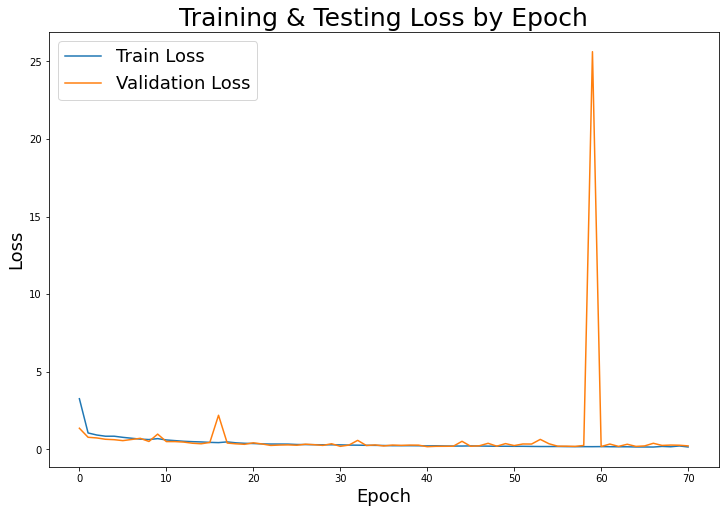

In [28]:
plot_hist(tl_model, 'loss')

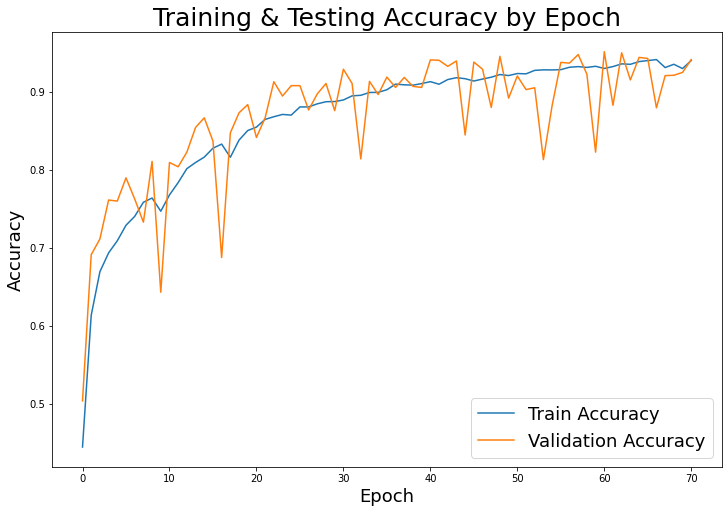

In [29]:
plot_hist(tl_model, 'accuracy')

In [30]:
test_pred = tl_model.model.predict(test_images_resized)
test_pred

array([[9.9712962e-01, 1.2671344e-04, 1.5442460e-04, ..., 1.9305422e-05,
        3.5325982e-05, 2.5280337e-03],
       [6.6879962e-05, 7.2183884e-03, 9.9265397e-01, ..., 4.9752515e-07,
        3.1013851e-06, 1.4216607e-05],
       [1.5918682e-05, 9.9998307e-01, 9.3577836e-07, ..., 4.2888495e-08,
        9.9317124e-11, 1.9363792e-12],
       ...,
       [6.5781728e-06, 1.3417215e-04, 3.2290089e-05, ..., 5.4917400e-05,
        2.2812977e-01, 7.7160060e-01],
       [4.4361373e-06, 1.5447377e-01, 8.4552139e-01, ..., 3.5290867e-07,
        7.1141519e-09, 9.7071586e-09],
       [9.9998224e-01, 1.2288780e-06, 2.5377442e-06, ..., 9.0550147e-06,
        5.0259177e-06, 3.2739276e-08]], dtype=float32)

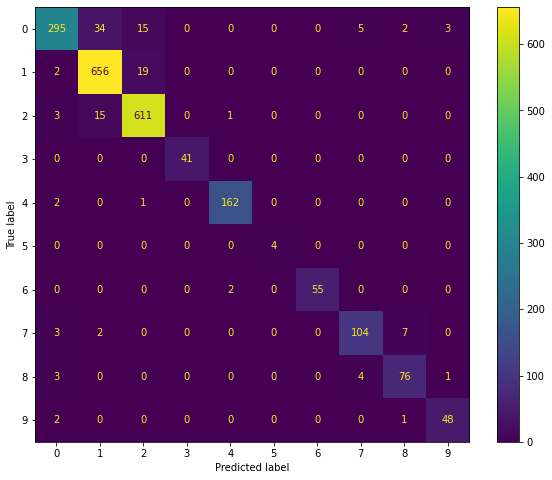

In [31]:
# Display results in a confusion matrix (older method for sklearn < 1.0) - multiclass classification - 0 to 9 classes
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize = (10,8))
ConfusionMatrixDisplay.from_predictions(test_labels.argmax(axis=1), test_pred.argmax(axis=1), ax=ax);
# 1's show where predictions failed, diagonal is correct. 0's no error.

In [35]:
print('Accuracy Score : ' + str(accuracy_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1))))
print("F1 score of each class: ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = None) )
print("F1_score (micro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'micro') ) #micro calculates positive and negative values globally:
print("F1_score (macro): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'macro') ) #macro, take the average of each class’s F-1 score:
print("F1_score (weighted): ", f1_score(test_labels.argmax(axis=1), test_pred.argmax(axis=1), average = 'weighted') )
#The class F-1 scores are averaged by using the number of instances in a class as weights:

Accuracy Score : 0.9417163836622304
F1 score of each class:  [0.88855422 0.94797688 0.95768025 1.         0.98181818 1.
 0.98214286 0.90829694 0.89411765 0.93203883]
F1_score (micro):  0.9417163836622305
F1_score (macro):  0.9492625810466645
F1_score (weighted):  0.9410975441914088
